## Assignment 7
Submitted by: **IEC2016012**   
Implement binary SVM to classify MNIST digits 3 and 8 using SMO Algorithm. Use different kernel functions(RBF, Polynomial at least) and generate ROC curve. Strictly divide(60:20:20) the data into train, validation and test splits. Perform all hyper parameter tuning/feature selection on validation data and report accuracy on test split. We suggest you to implement the SMO algorithm by yourself for which 10 bonus points will be given, but if you find it difficult, you are free to use third party implementation".

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import random as rnd
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Loading dataset

In [2]:
mnist = fetch_mldata('MNIST original')

/home/subtleseeker/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/subtleseeker/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
data = mnist['data']
target = mnist['target']

In [4]:
target = target.astype(int)
data = data.astype(int)

## Separating images of 3 and 8

In [5]:
indices = []
for i, val in enumerate(target):
    if val==3 or val==8:
        indices.append(i)

In [6]:
X = data[indices]
y = target[indices]

In [7]:
X, y = shuffle(X, y, random_state=0)

In [8]:
X = X[:3000]
y = y[:3000]

In [9]:
y_new = np.zeros((len(y)))

In [10]:
for i in range(len(y)):
    if y[i]==3:
        y_new[i]=1
    else:
        y_new[i]=-1

## Dividing dataset into train, validation, test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
plt.imshow(np.reshape(X_train[0],(28,28)))
print(y_train[0])
plt.show()

In [12]:
#Hyperparameters
C = 1.0
tol = 0.01
max_iter = 1000
tau = 5
epsilon = 0.001

In [13]:
def kernel_linear(x1, x2):
    return np.dot(x1, x2.T)
def kernel_quadratic(x1, x2):
    return (np.square(np.dot(x1, x2.T)))
def kernel_gaussian(x1, x2):
    return np.sum(np.exp(-np.square(np.linalg.norm(x1-x2))/(2*tau*tau)))
def kernel_rbf(x1, x2):
    return np.sum(np.exp(-np.square(np.linalg.norm(x1-x2))/1))

In [14]:
def calc_b(X, y, w):
    b_tmp = y.reshape((y.shape[0],1)) - np.dot(X, w)
    return np.mean(b_tmp)
def calc_w(alpha, y, X):
    return np.dot(X.T, np.multiply(alpha,y).reshape((X.shape[0],1)))
def h(X, w, b):
    if len(X.shape)==1:
        return np.sign(np.dot(w.T, X.reshape(X.shape[0],1)) + b).T
    else:
        return np.sign(np.dot(w.T, X.T) + b).T
def E(x_k, y_k, w, b):
    return h(x_k, w, b) - y_k
def compute_L_H(C, alphaj_old, alphai_old, yj, yi):
    if(yi != yj):
        return (max(0, alphaj_old - alphai_old), min(C, C - alphai_old + alphaj_old))
    else:
        return (max(0, alphai_old + alphaj_old - C), min(C, alphai_old + alphaj_old))
def get_rnd_int(a,b,z):
    j = z
    cnt=0
    while j == z and cnt<1000:
        j = rnd.randint(a,b)
        cnt=cnt+1
    return j

In [15]:
kernels = {
            'linear' : kernel_linear,
            'quadratic' : kernel_quadratic,
            'gaussian' : kernel_gaussian,
            'rbf': kernel_rbf,
}

In [16]:
def SVM_train(X,y,k="linear"):
    n, d = X.shape[0], X.shape[1]
    alpha = np.zeros((n))
    count = 0
    while True:
        count += 1
        alpha_prev = np.copy(alpha)
        for j in range(0, n):
            i = get_rnd_int(0, n-1, j)
            x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
            k_ij = kernels[k](x_i, x_i) + kernels[k](x_j, x_j) - 2 * kernels[k](x_i, x_j)
            if k_ij == 0:
                continue
            alphaold_j, alphaold_i = alpha[j], alpha[i]
            (L, H) = compute_L_H(C, alphaold_j, alphaold_i, y_j, y_i)

            w = calc_w(alpha, y, X)
            b = calc_b(X, y, w)

            E_i = E(x_i, y_i, w, b)
            E_j = E(x_j, y_j, w, b)

            alpha[j] = alphaold_j + float(y_j * (E_i - E_j))/k_ij
            alpha[j] = max(alpha[j], L)
            alpha[j] = min(alpha[j], H)

            alpha[i] = alphaold_i + y_i*y_j * (alphaold_j - alpha[j])

        # Check convergence
        diff = np.linalg.norm(alpha - alpha_prev)
        if diff < epsilon:
            break

        if count >= max_iter:
            print("Iteration number exceeded the max of %d iterations" % (max_iter))
            return
    # Compute final model parameters
    w = calc_w(alpha, y, X)
    b = calc_b(X, y, w)
    # Get support vectors
    alpha_idx = np.where(alpha > 0)[0]
    support_vectors = X[alpha_idx, :]   
    return support_vectors, count, b, w

In [17]:
#Predict kar lo frands
def predict(X, w, b):
        return h(X, w, b)
def calc_acc(y, y_hat):
    idx = np.where(y_hat == 1)
    print(y.shape)
    print(y_hat.shape)
    TP = np.sum(y_hat[idx] == y[idx])
    idx = np.where(y_hat == -1)
    TN = np.sum(y_hat[idx] == y[idx])
    return float(TP + TN)/len(y)

In [18]:
sup, itera, b_ , w_ = SVM_train(X_train, y_train)

## Test Accuracy

In [19]:
y_pred = predict(X_test, w_, b_)
y_pred = y_pred.flatten()
print(calc_acc(y_test,y_pred))

(600,)
(600,)
0.9333333333333333


## Hyperparameter tuning on the validation dataset

In [22]:
Cs = [1, 10, 100]
for k in kernels:
    print("Kernel:",k)
    for i in range(len(Cs)):
        C = Cs[i]
        sup, itera, b_ , w_ = SVM_train(X_train, y_train, k)
        print("C ",C)
        y_pred = predict(X_val, w_, b_)
        y_pred = y_pred.flatten()
        print("Accuracy:",calc_acc(y_val,y_pred))


Kernel: linear
C  1
(480,)
(480,)
Accuracy: 0.9645833333333333
C  10
(480,)
(480,)
Accuracy: 0.9520833333333333
C  100

(480,)
(480,)
Accuracy: 0.9583333333333334
Kernel: quadratic
C  1
(480,)
(480,)
Accuracy: 0.525
C  10
(480,)
(480,)
Accuracy: 0.525
C  100
(480,)
(480,)
Accuracy: 0.525
Kernel: gaussian
C  1
(480,)
(480,)
Accuracy: 0.9479166666666666


In [23]:
y_pred = predict(X_test, w_, b_)
y_pred = y_pred.flatten()
print(calc_acc(y_test,y_pred))

(600,)
(600,)
0.9366666666666666


In [24]:
sup, itera, b_ , w_ = SVM_train(X_train, y_train)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
y_test_c = y_test.copy()
y_test_c = label_binarize(y_test_c, classes=[-1, 1])

In [25]:
fpr, tpr, _ = roc_curve(y_test_c[:], y_pred[:])
roc_auc = auc(fpr, tpr)

In [26]:
roc_auc

0.9362092549961631

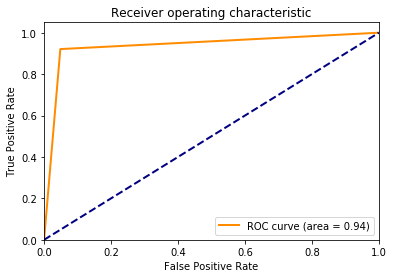

In [28]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### For RBF

In [31]:
sup, itera, b_ , w_ = SVM_train(X_train, y_train, k='rbf')

Accuracy: 0.9479166666666666
